In [3]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive


In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
zip_path = '/content/drive/MyDrive/Dataset/archive (14).zip'  # correct name
extract_path = '/content/drive/MyDrive/Dataset/'

import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [6]:

# Set directory paths
base_dir = '/content/drive/MyDrive/Dataset/covid_update'
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Test')

In [7]:
# Check directory contents
print("Train directory:", os.listdir(train_dir))
print("Test directory:", os.listdir(validation_dir))

train_covid_dir = os.path.join(train_dir, 'covid')
train_non_covid_dir = os.path.join(train_dir, 'non_covid')

validation_covid_dir = os.path.join(validation_dir, 'covid')
validation_non_covid_dir = os.path.join(validation_dir, 'non_covid')

Train directory: ['covid', 'non_covid']
Test directory: ['covid', 'non_covid']


In [8]:
num_covid_tr = len(os.listdir(train_covid_dir))
num_non_covid_tr = len(os.listdir(train_non_covid_dir))
num_covid_val = len(os.listdir(validation_covid_dir))
num_non_covid_val = len(os.listdir(validation_non_covid_dir))

In [9]:
total_train = num_covid_tr + num_non_covid_tr
total_val = num_covid_val + num_non_covid_val

print('Training COVID images:', num_covid_tr)
print('Training Non-COVID images:', num_non_covid_tr)
print('Validation COVID images:', num_covid_val)
print('Validation Non-COVID images:', num_non_covid_val)
print('Total training:', total_train)
print('Total validation:', total_val)

Batch_Size = 16
Image_Size = 224

Training COVID images: 250
Training Non-COVID images: 203
Validation COVID images: 100
Validation Non-COVID images: 119
Total training: 453
Total validation: 219


In [10]:
def preprocess_input_vgg(x):
    # x is normalized in [0,1], scale to [0,255]
    x = x * 255.0
    return tf.keras.applications.vgg16.preprocess_input(x)

# Training data generator with augmentation
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input_vgg
)

In [11]:
image_gen_val = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input_vgg
)

# To handle grayscale images but VGG16 expects 3 channels, we use color_mode='rgb'
# The generator will repeat grayscale channel 3 times automatically if images are grayscale.
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=Batch_Size,
    directory=train_dir,
    target_size=(Image_Size, Image_Size),
    color_mode='rgb',  # convert grayscale images to 3 channel
    class_mode='binary',
    shuffle=True
)

Found 453 images belonging to 2 classes.


In [12]:
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=Batch_Size,
    directory=validation_dir,
    target_size=(Image_Size, Image_Size),
    color_mode='rgb',
    class_mode='binary',
    shuffle=False
)

# Load VGG16 base model without top layer, input shape adjusted for RGB images 224x224
base_model = tf.keras.applications.VGG16(weights='imagenet',
                                         include_top=False,
                                         input_shape=(Image_Size, Image_Size, 3))

# Freeze base model layers
base_model.trainable = False


Found 219 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
epochs = 15
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / Batch_Size)),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / Batch_Size)),
    callbacks=[early_stop]
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 379s 13s/step - accuracy: 0.7379 - loss: 11.4469 - val_accuracy: 0.8813 - val_loss: 4.8987
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 397s 14s/step - accuracy: 0.9365 - loss: 1.7772 - val_accuracy: 0.8676 - val_loss: 6.6119
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 417s 13s/step - accuracy: 0.9650 - loss: 0.8384 - val_accuracy: 0.7717 - val_loss: 14.2249
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 378s 13s/step - accuracy: 0.9844 - loss: 0.3416 - val_accuracy: 0.8630 - val_loss: 7.3948


In [14]:
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

Final Training Accuracy: 0.9845
Final Validation Accuracy: 0.8630


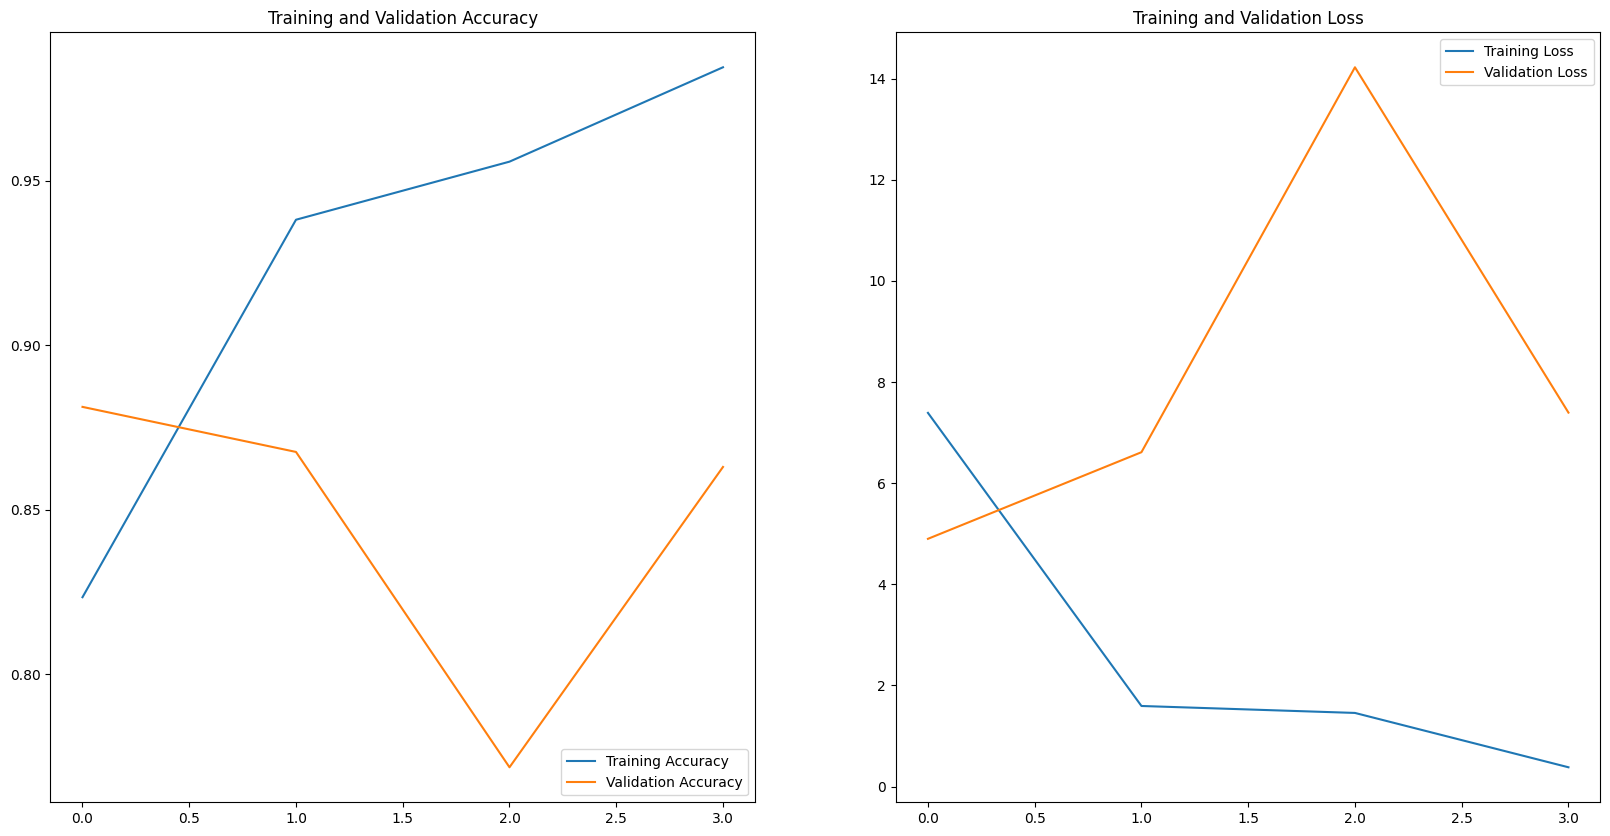

In [15]:
# Plot training/validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # use actual number of trained epochs

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 120s 9s/step
              precision    recall  f1-score   support

    COVID-19       0.82      0.95      0.88       100
      NORMAL       0.95      0.82      0.88       119

    accuracy                           0.88       219
   macro avg       0.89      0.89      0.88       219
weighted avg       0.89      0.88      0.88       219



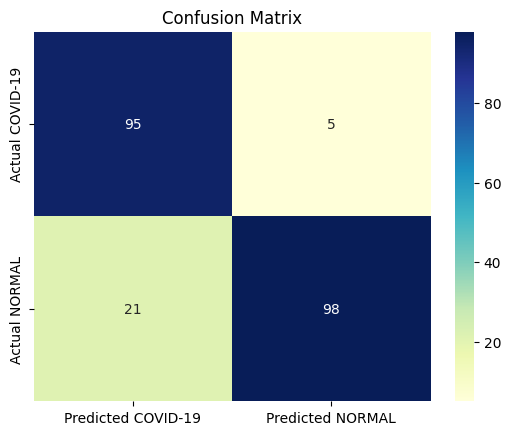

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict
validation_steps = int(np.ceil(total_val / Batch_Size))
predictions = model.predict(val_data_gen, steps=validation_steps)
predicted_classes = (predictions > 0.5).astype('int32').reshape(-1)
true_classes = val_data_gen.classes

# Report
print(classification_report(true_classes, predicted_classes, target_names=['COVID-19', 'NORMAL']))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=['Predicted COVID-19', 'Predicted NORMAL'],
            yticklabels=['Actual COVID-19', 'Actual NORMAL'])
plt.title("Confusion Matrix")
plt.show()


In [17]:
model.save('covid_classifier_model.h5')


In [18]:
from tensorflow.keras.models import load_model

model = load_model('covid_classifier_model.h5')

In [19]:
from tensorflow.keras.preprocessing import image

img = image.load_img('/content/drive/MyDrive/Dataset/covid_update/Test/non_covid/patient00015-study2-view1_frontal.jpg', target_size=(224,224))

In [20]:
x = image.img_to_array(img)
x

array([[[71., 71., 71.],
        [13., 13., 13.],
        [ 3.,  3.,  3.],
        ...,
        [11., 11., 11.],
        [11., 11., 11.],
        [11., 11., 11.]],

       [[53., 53., 53.],
        [12., 12., 12.],
        [ 1.,  1.,  1.],
        ...,
        [11., 11., 11.],
        [11., 11., 11.],
        [11., 11., 11.]],

       [[58., 58., 58.],
        [10., 10., 10.],
        [ 2.,  2.,  2.],
        ...,
        [11., 11., 11.],
        [11., 11., 11.],
        [11., 11., 11.]],

       ...,

       [[23., 23., 23.],
        [33., 33., 33.],
        [46., 46., 46.],
        ...,
        [74., 74., 74.],
        [73., 73., 73.],
        [64., 64., 64.]],

       [[25., 25., 25.],
        [28., 28., 28.],
        [45., 45., 45.],
        ...,
        [77., 77., 77.],
        [68., 68., 68.],
        [71., 71., 71.]],

       [[26., 26., 26.],
        [33., 33., 33.],
        [49., 49., 49.],
        ...,
        [89., 89., 89.],
        [88., 88., 88.],
        [62., 62., 62.]]

In [21]:
x.shape

(224, 224, 3)

In [22]:
x = x/255

In [23]:
from tensorflow.keras.applications.resnet50 import preprocess_input

x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [24]:
model.predict(img_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


array([[3.844183e-12]], dtype=float32)

In [25]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


In [26]:
if(a==1):
    print("The person does not have COVID-19")
else:
    print("The person has COVID-19")

The person has COVID-19


14/14 ━━━━━━━━━━━━━━━━━━━━ 123s 9s/step


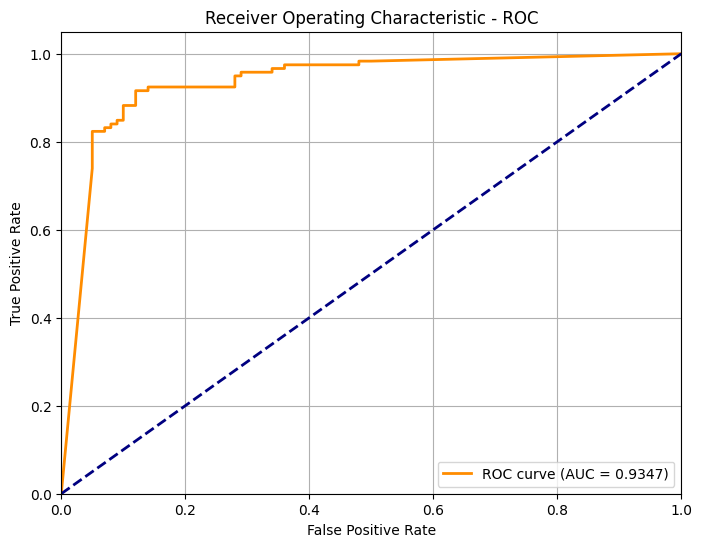

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions (probabilities, not classes)
y_pred_proba = model.predict(val_data_gen, steps=int(np.ceil(total_val / Batch_Size)))

# True labels
y_true = val_data_gen.classes

# If predictions have shape (N, 1), flatten them
if y_pred_proba.shape[1] == 1:
    y_scores = y_pred_proba.ravel()
else:  # if using softmax with 2 outputs
    y_scores = y_pred_proba[:, 1]  # probability for class "1" (NORMAL in your case)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()